# Microstructure characterization of battery materials based on voxelated image data: Computation of active surface area and tortuosity

## Second validation example: FCC structure

<div class="row">
  <div class="col-md-7" markdown="1">
  This validation increases the complexity of the first example by adding contact between spherical bodies while the volume fraction and surface area can still be expressed analytically as a function of the unit cell side length. This validation is well suited as
<ul>
  <li>the surface is analytically known,</li>
  <li>the example is 3D but yet simple,</li>
  <li>the surface is curved and, thus, will suffer from pixelation issues</li>
  <li>the example can be used to compute tortuosity in the solid and the pore space.</li>
</ul>
<br>
Without a defined overlap, a voxelization issue arises where for all configurations with an even number of voxels per cube length the spheres are touching at voxel edges while for all odd configurations the spheres are fully connected. This can be seen in the front view of the cube:
  </div>
  <div class="col-md-5" markdown="1">
  <img src="data-paper/fcc-study/fcc_solid_3D.png" alt="Image 1" width="220" />
  </div>
</div>
<br>

<div class="row">
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_10_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_11_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_50_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_51_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_100_pure.png" alt="Image 1" width="100" />
</div>
<div class="col-md-2" markdown="1">
  <img src="data-paper/fcc-study/fcc_101_pure.png" alt="Image 1" width="100" />
</div>
</div>
<div class="row">
<div class="col-md-2" markdown="1">
  $10^3$ voxels 
</div>
<div class="col-md-2" markdown="1">
  $11^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $50^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $51^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $100^3$ voxels
</div>
<div class="col-md-2" markdown="1">
  $101^3$ voxels
</div>
</div>


**Author**: Simon Daubner<br>
**Department**: Department of Mechanical Engineering<br>
**Institution**: Karlsruhe Institute of Technology

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import taufactor.metrics as tau

import metrics
import data
import time

We initialize the grid resolution as

In [2]:
dx = 1.0
dy = dx

In [3]:
fcc_results = {}
overlaps = [0.0,0.05] #[0.01,0.05,0.1,0.2]

for overlap in overlaps:
    resolution = [6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,50,51,100,101,200,201,300,301]
    
    # Initialize fields
    fcc_vol_fraction = {'theo':np.zeros(len(resolution)),
                        'num':np.zeros(len(resolution))}

    methods = ['theo', 'faces', 'marching', 'conv_marching', 'porespy', 'gradient', 'conv_gradient']
    area = {method: np.zeros(len(resolution)) for method in methods}
    times = {method: np.zeros(len(resolution)) for method in methods[1:]}
    
    connectivity_type = ['s_side', 's_edge', 's_corner', 'p_side', 'p_edge', 'p_corner']
    connectivity = {conn: np.zeros(len(resolution)) for conn in connectivity_type}
    tortuosity   = {'solid': np.zeros(len(resolution)),
                    'pore': np.zeros(len(resolution))}
    
    for i, pixels in enumerate(resolution):
        sharp_field = data.create_fcc_cube(pixels, overlap=overlap)
        vol, surf = data.theoretical_fcc_metrics(pixels, overlap)
        fcc_vol_fraction['theo'][i] = vol
        fcc_vol_fraction['num'][i] = metrics.volume_fraction(sharp_field, 1)
        
        timer=[]
        area['theo'][i] = surf
        timer.append(time.time())
        area['faces'][i] = 3*tau.surface_area(sharp_field, phases=[1]).item()
        timer.append(time.time())
        area['marching'][i] = metrics.specific_surface_area_marching(sharp_field)
        timer.append(time.time())
        phase_field = metrics.smooth_with_convolution(sharp_field)
        area['conv_marching'][i] = metrics.specific_surface_area_marching(phase_field)
        timer.append(time.time())
        area['porespy'][i]  = metrics.specific_surface_area_porespy(sharp_field)
        timer.append(time.time())
        area['gradient'][i] = metrics.specific_surface_area(sharp_field)
        timer.append(time.time())
        area['conv_gradient'][i] = metrics.specific_surface_area(sharp_field, smooth=1)
        timer.append(time.time())
        
        for k, method in enumerate(methods[1:]):
            times[method][i] = np.array(timer)[k+1]-np.array(timer)[k]
        
        # Compute through feature and tortuosity
        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 1, 'x')
        connectivity['s_side'][i] = through_fraction[0]
        connectivity['s_edge'][i] = through_fraction[1]
        connectivity['s_corner'][i] = through_fraction[2]
        
        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0])
            if res<1000: tortuosity['solid'][i] = res
            
        through_feature, through_fraction = metrics.extract_through_feature(sharp_field, 0, 'x')
        connectivity['p_side'][i] = through_fraction[0]
        connectivity['p_edge'][i] = through_fraction[1]
        connectivity['p_corner'][i] = through_fraction[2]
        
        if through_fraction[0]>0.0:
            res = metrics.tortuosity(through_feature[0])
            if res<1000: tortuosity['pore'][i] = res
        print(f"Finished FCC with {pixels}^3 voxels.")
        
    fcc_results[f'overlap{int(100*overlap)}'] = {'vol':fcc_vol_fraction,
                                                 'area':area,
                                                 'time':times,
                                                 'connected':connectivity,
                                                 'taufactor':tortuosity}

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 1.7881393432617188e-07, tau: 2.3333334922790527
converged to: 2.3333334922790527                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 6^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.4615386426448822, tau: 1.3485714197158813
Iter: 100, conv error: 1.2106788460641837e-07, tau: 2.445708751678467
converged to: 2.445708751678467                   after: 101 iterations in: 0.0163                    seconds at a rate of 0.0002 s/iter
Finished FCC with 7^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Finished FCC with 8^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0003                    seconds at a rate of 0.0004 s/iter
converged to: inf                   after: 1 iterations in: 0.0003                    seconds at a rate of 0.0003 s/iter
Finished FCC with 9^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 2.980231954552437e-07, tau: 2.5999999046325684
converged to: 2.5999999046325684                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
Finished FCC with 10^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0005                    seconds at a rate of 0.0006 s/iter
converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0007 s/iter
Finished FCC with 11^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.6666669845581055, tau: 2.222222089767456
Iter: 100, conv error: 1.3194979146646801e-05, tau: 2.555558204650879
converged to: 2.555558204650879                   after: 101 iterations in: 0.0162                    seconds at a rate of 0.0002 s/iter
Finished FCC with 12^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.3047619163990021, tau: 1.187660574913025
Iter: 100, conv error: 0.00020653908723033965, tau: 2.3880302906036377
converged to: 2.3880302906036377                   after: 101 iterations in: 0.016                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.2000000476837158, tau: 1.9391025304794312
Iter: 100, conv error: 0.0004613788041751832, tau: 4.091120719909668
converged to: 4.091120719909668                   after: 101 iterations in: 0.0169                    seconds at a rate of 0.0002 s/iter
Finished FCC with 13^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.44444504380226135, tau: 1.634920597076416
Iter: 100, conv error: 0.00015978896408341825, tau: 2.7367353439331055
converged to: 2.7367353439331055                   after: 101 iterations in: 0.0162                    seconds at a rate of 0.0002 s/iter
Finished FCC with 14^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.3098592758178711, tau: 1.171790599822998
Iter: 100, conv error: 0.0007144740084186196, tau: 2.7080395221710205
converged to: 2.7080395221710205                   after: 101 iterations in: 0.0199                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.012345790863037, tau: 1.5232824087142944
Iter: 100, conv error: 0.0009298816439695656, tau: 3.461679220199585
converged to: 3.461679220199585                   after: 101 iterations in: 0.0185                    seconds at a rate of 0.0002 s/iter
Finished FCC with 15^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 1.2727272510528564, tau: 1.5113636255264282
Iter: 100, conv error: 0.0024491893127560616, tau: 3.6577847003936768
Iter: 200, conv error: 2.112238917106879e-06, tau: 3.659306764602661
converged to: 3.659306764602661                   after: 201 iterations in: 0.0319                    seconds at a rate of 0.0002 s/iter
Finished FCC with 16^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0004                    seconds at a rate of 0.0004 s/iter
converged to: inf                   after: 1 iterations in: 0.0004                    seconds at a rate of 0.0004 s/iter
Finished FCC with 17^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 1.0000004768371582, tau: 1.5095783472061157
Iter: 100, conv error: 0.00550785893574357, tau: 3.5371134281158447
Iter: 200, conv error: 7.287979769898811e-06, tau: 3.5402097702026367
converged to: 3.5402097702026367                   after: 201 iterations in: 0.0321                    seconds at a rate of 0.0002 s/iter
Finished FCC with 18^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.3179919421672821, tau: 1.1326295137405396
Iter: 100, conv error: 0.006634412799030542, tau: 2.9671061038970947
Iter: 200, conv error: 1.6561836673645303e-05, tau: 2.9760935306549072
converged to: 2.9760935306549072                   after: 201 iterations in: 0.0369                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.6356591582298279, tau: 1.3918979167938232
Iter: 100, conv error: 0.00370724662207067, tau: 2.799781084060669
Iter: 200, conv error: 6.300478617049521e-06, tau: 2.8001902103424072
converged to: 2.8001902103424072                   after: 201 iterations in: 0.0413                    seconds at a rate of 0.0002 s/iter
Finished FCC with 19^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.8888888359069824, tau: 1.4487806558609009
Iter: 100, conv error: 0.00495304586365819, tau: 3.1392946243286133
Iter: 200, conv error: 3.5539102100301534e-05, tau: 3.1418917179107666
converged to: 3.1418917179107666                   after: 201 iterations in: 0.0358                    seconds at a rate of 0.0002 s/iter
Finished FCC with 20^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.2925989031791687, tau: 1.1153968572616577
Iter: 100, conv error: 0.009443068876862526, tau: 2.8968725204467773
Iter: 200, conv error: 5.119818524690345e-05, tau: 2.8817901611328125
Iter: 300, conv error: 2.3191071250039386e-06, tau: 2.8818037509918213
converged to: 2.8818037509918213                   after: 301 iterations in: 0.0554                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.8901736736297607, tau: 1.3270200490951538
Iter: 100, conv error: 0.006392448674887419, tau: 2.836069345474243
Iter: 200, conv error: 4.450547930900939e-05, tau: 2.837646722793579
converged to: 2.837646722793579                   after: 201 iterations in: 0.0306                    seconds at a rate of 0.0002 s/iter
Finished FCC with 21^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.6400001645088196, tau: 1.3354474306106567
Iter: 100, conv error: 0.010023124516010284, tau: 2.4629838466644287
Iter: 200, conv error: 2.2149526557768695e-05, tau: 2.4660120010375977
converged to: 2.4660120010375977                   after: 201 iterations in: 0.0373                    seconds at a rate of 0.0002 s/iter
Finished FCC with 22^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.2719540596008301, tau: 1.1063315868377686
Iter: 100, conv error: 0.013947670347988605, tau: 3.170393705368042
Iter: 200, conv error: 8.750910637900233e-05, tau: 3.1702024936676025
converged to: 3.1702024936676025                   after: 201 iterations in: 0.0414                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.7692307829856873, tau: 1.311725378036499
Iter: 100, conv error: 0.012092030607163906, tau: 2.681035041809082
Iter: 200, conv error: 0.0001246118772542104, tau: 2.6811726093292236
converged to: 2.6811726093292236                   after: 201 iterations in: 0.0314                    seconds at a rate of 0.0002 s/iter
Finished FCC with 23^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.7586208581924438, tau: 1.3191057443618774
Iter: 100, conv error: 0.0130686704069376, tau: 2.596418619155884
Iter: 200, conv error: 0.00016761427104938775, tau: 2.6008362770080566
converged to: 2.6008362770080566                   after: 201 iterations in: 0.0396                    seconds at a rate of 0.0002 s/iter
Finished FCC with 24^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
converged to: inf                   after: 1 iterations in: 0.0005                    seconds at a rate of 0.0005 s/iter
Finished FCC with 25^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.6092721819877625, tau: 1.1285394430160522
Iter: 100, conv error: 0.1047578901052475, tau: 1.9721612930297852
Iter: 200, conv error: 0.02821732498705387, tau: 1.990267276763916
Iter: 300, conv error: 0.0010779370786622167, tau: 1.9894299507141113
Iter: 400, conv error: 0.00016844690253492445, tau: 1.9902729988098145
converged to: 1.9902729988098145                   after: 401 iterations in: 0.0872                    seconds at a rate of 0.0002 s/iter
Finished FCC with 50^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.23386500775814056, tau: 1.0455803871154785
Iter: 100, conv error: 0.07434220612049103, tau: 3.515052080154419
Iter: 200, conv error: 0.019070692360401154, tau: 4.289057731628418
Iter: 300, conv error: 0.004213749896734953, tau: 4.278545379638672
Iter: 400, conv error: 0.001225374755449593, tau: 4.282629489898682
Iter: 500, conv error: 0.00034503397182561457, tau: 4.284670352935791
converged to: 4.284670352935791                   after: 501 iterations in: 0.1204                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.5904762148857117, tau: 1.123306393623352
Iter: 100, conv error: 0.14032518863677979, tau: 1.981895923614502
Iter: 200, conv error: 0.027414577081799507, tau: 1.9982943534851074
Iter: 300, conv error: 0.0018062104936689138, tau: 1.9963657855987549
Iter: 400, conv error: 0.0004132743924856186, tau: 1.9970026016235352
converged to: 1.9970026016235352                   after: 401 iterations in: 0.0746                    seconds at a 

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.5443234443664551, tau: 1.0616776943206787
Iter: 100, conv error: 0.3967971205711365, tau: 1.7994718551635742
Iter: 200, conv error: 0.11346997320652008, tau: 1.7953132390975952
Iter: 300, conv error: 0.07955275475978851, tau: 1.8333255052566528
Iter: 400, conv error: 0.02368094027042389, tau: 1.8121211528778076
Iter: 500, conv error: 0.003745060181245208, tau: 1.8163297176361084
Iter: 600, conv error: 0.0015564386267215014, tau: 1.813551664352417
Iter: 700, conv error: 0.0011176662519574165, tau: 1.814141869544983
Iter: 800, conv error: 0.00023904362751636654, tau: 1.8141398429870605
converged to: 1.8141398429870605                   after: 801 iterations in: 3.0545                    seconds at a rate of 0.0038 s/iter
Finished FCC with 100^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.20675240457057953, tau: 1.0225775241851807
Iter: 100, conv error: 1.94001042842865, tau: -19.907007217407227
converged to: -19.907007217407227                   after: 101 iterations in: 0.3934                    seconds at a rate of 0.0039 s/iter
Iter: 0, conv error: 0.5382851958274841, tau: 1.0592001676559448
Iter: 100, conv error: 0.41622063517570496, tau: 1.8019667863845825
Iter: 200, conv error: 0.12733182311058044, tau: 1.7972363233566284
Iter: 300, conv error: 0.07612782716751099, tau: 1.831168532371521
Iter: 400, conv error: 0.021935466676950455, tau: 1.8121966123580933
Iter: 500, conv error: 0.0028850743547081947, tau: 1.813828468322754
Iter: 600, conv error: 0.0032262704335153103, tau: 1.8114360570907593
Iter: 700, conv error: 0.0011146079050377011, tau: 1.8116437196731567
Iter: 800, conv error: 0.00027749373111873865, tau: 1.8117092847824097
converged to: 1.8117092847824097                   after: 801 iterations in: 3.312                    seconds at

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.5119104385375977, tau: 1.0296550989151
Iter: 100, conv error: 0.8796414136886597, tau: 1.7747912406921387
Iter: 200, conv error: 0.38257139921188354, tau: 1.7156271934509277
Iter: 300, conv error: 0.144769549369812, tau: 1.6909594535827637
Iter: 400, conv error: 0.10633918642997742, tau: 1.6972724199295044
Iter: 500, conv error: 0.05515377223491669, tau: 1.7095234394073486
Iter: 600, conv error: 0.06603207439184189, tau: 1.7318934202194214
Iter: 700, conv error: 0.034544412046670914, tau: 1.706863522529602
Iter: 800, conv error: 0.018978046253323555, tau: 1.7170932292938232
Iter: 900, conv error: 0.01303932536393404, tau: 1.7160990238189697
Iter: 1000, conv error: 0.004179906565696001, tau: 1.7189298868179321
Iter: 1100, conv error: 0.003266112180426717, tau: 1.7165708541870117
Iter: 1200, conv error: 0.0023503322154283524, tau: 1.7164068222045898
Iter: 1300, conv error: 0.0009378608665429056, tau: 1.7170381546020508
converged to: 1.7170381546020508              

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.2017693966627121, tau: 1.0112593173980713
Iter: 100, conv error: 0.503218412399292, tau: 4.870006561279297
Iter: 200, conv error: 0.9653324484825134, tau: -7.569298267364502
converged to: -7.569298267364502                   after: 201 iterations in: 10.3372                    seconds at a rate of 0.0514 s/iter
Iter: 0, conv error: 0.5133678317070007, tau: 1.0290614366531372
Iter: 100, conv error: 0.8817248940467834, tau: 1.7758153676986694
Iter: 200, conv error: 0.3998286724090576, tau: 1.7139103412628174
Iter: 300, conv error: 0.15588073432445526, tau: 1.6831039190292358
Iter: 400, conv error: 0.12520180642604828, tau: 1.6963145732879639
Iter: 500, conv error: 0.06733214855194092, tau: 1.7091922760009766
Iter: 600, conv error: 0.06714469194412231, tau: 1.7293425798416138
Iter: 700, conv error: 0.03180662542581558, tau: 1.7034664154052734
Iter: 800, conv error: 0.019931664690375328, tau: 1.715141773223877
Iter: 900, conv error: 0.013672059401869774, tau: 1.71425

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.49755793809890747, tau: 1.0195196866989136
Iter: 100, conv error: 0.6300912499427795, tau: 1.928469181060791
Iter: 200, conv error: 0.5943421721458435, tau: 1.6896097660064697
Iter: 300, conv error: 0.3933882713317871, tau: 1.685767650604248
Iter: 400, conv error: 0.23897260427474976, tau: 1.6088793277740479
Iter: 500, conv error: 0.20249991118907928, tau: 1.7533971071243286
Iter: 600, conv error: 0.10376495122909546, tau: 1.6645139455795288
Iter: 700, conv error: 0.14526359736919403, tau: 1.6947951316833496
Iter: 800, conv error: 0.05079330876469612, tau: 1.6624929904937744
Iter: 900, conv error: 0.057645510882139206, tau: 1.697899341583252
Iter: 1000, conv error: 0.0456145703792572, tau: 1.6780908107757568
Iter: 1100, conv error: 0.01794644258916378, tau: 1.6834146976470947
Iter: 1200, conv error: 0.017552915960550308, tau: 1.6847004890441895
Iter: 1300, conv error: 0.005104848183691502, tau: 1.6881012916564941
Iter: 1400, conv error: 0.008663150481879711, tau:

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.19669722020626068, tau: 1.0074893236160278
Iter: 100, conv error: 1.0284318923950195, tau: 2.2461800575256348
Iter: 200, conv error: 4.246833324432373, tau: -204.09620666503906
converged to: -204.09620666503906                   after: 201 iterations in: 32.3333                    seconds at a rate of 0.1609 s/iter
Iter: 0, conv error: 0.5038198828697205, tau: 1.0192523002624512
Iter: 100, conv error: 0.8736239075660706, tau: 1.9353257417678833
Iter: 200, conv error: 0.6203562021255493, tau: 1.689356803894043
Iter: 300, conv error: 0.4057484567165375, tau: 1.687663197517395
Iter: 400, conv error: 0.24366067349910736, tau: 1.6082892417907715
Iter: 500, conv error: 0.252986341714859, tau: 1.7591404914855957
Iter: 600, conv error: 0.1201200932264328, tau: 1.6668062210083008
Iter: 700, conv error: 0.14852117002010345, tau: 1.6959694623947144
Iter: 800, conv error: 0.05530649423599243, tau: 1.6636627912521362
Iter: 900, conv error: 0.062030114233493805, tau: 1.6987116

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 1.7881393432617188e-07, tau: 2.3333334922790527
converged to: 2.3333334922790527                   after: 1 iterations in: 0.0005                    seconds at a rate of 0.0006 s/iter
Finished FCC with 6^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.2456141710281372, tau: 1.3052414655685425
Iter: 100, conv error: 4.067479153491149e-07, tau: 1.7686947584152222
converged to: 1.7686947584152222                   after: 101 iterations in: 0.0114                    seconds at a rate of 0.0001 s/iter
Finished FCC with 7^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Finished FCC with 8^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0003                    seconds at a rate of 0.0004 s/iter
Finished FCC with 9^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.4000003933906555, tau: 1.2544000148773193
Iter: 100, conv error: 5.033302841184195e-06, tau: 2.0184361934661865
converged to: 2.0184361934661865                   after: 101 iterations in: 0.0175                    seconds at a rate of 0.0002 s/iter
Finished FCC with 10^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0005                    seconds at a rate of 0.0005 s/iter
Finished FCC with 11^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.24000009894371033, tau: 1.157024621963501
Iter: 100, conv error: 4.1534469346515834e-05, tau: 1.5909491777420044
converged to: 1.5909491777420044                   after: 101 iterations in: 0.0161                    seconds at a rate of 0.0002 s/iter
Finished FCC with 12^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.24434398114681244, tau: 1.1813690662384033
Iter: 100, conv error: 9.679552749730647e-05, tau: 1.9655290842056274
converged to: 1.9655290842056274                   after: 101 iterations in: 0.0167                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.2000000476837158, tau: 1.9682273864746094
Iter: 100, conv error: 0.0004516431363299489, tau: 5.432131290435791
converged to: 5.432131290435791                   after: 101 iterations in: 0.0164                    seconds at a rate of 0.0002 s/iter
Finished FCC with 13^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.26086995005607605, tau: 1.1777535676956177
Iter: 100, conv error: 0.00027073262026533484, tau: 2.715707302093506
converged to: 2.715707302093506                   after: 101 iterations in: 0.0172                    seconds at a rate of 0.0002 s/iter
Finished FCC with 14^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.29126206040382385, tau: 1.1260340213775635
Iter: 100, conv error: 0.00018945138435810804, tau: 1.516472339630127
converged to: 1.516472339630127                   after: 101 iterations in: 0.019                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.076923131942749, tau: 1.8480390310287476
Iter: 100, conv error: 0.002440214855596423, tau: 5.93410587310791
Iter: 200, conv error: 4.460991021915106e-06, tau: 5.936267375946045
converged to: 5.936267375946045                   after: 201 iterations in: 0.0356                    seconds at a rate of 0.0002 s/iter
Finished FCC with 15^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.2978723347187042, tau: 1.1479099988937378
Iter: 100, conv error: 0.0009425338939763606, tau: 2.0886662006378174
converged to: 2.0886662006378174                   after: 101 iterations in: 0.0159                    seconds at a rate of 0.0002 s/iter
Finished FCC with 16^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0005                    seconds at a rate of 0.0005 s/iter
converged to: inf                   after: 1 iterations in: 0.0004                    seconds at a rate of 0.0005 s/iter
Finished FCC with 17^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.32381001114845276, tau: 1.137270450592041
Iter: 100, conv error: 0.0041380347684025764, tau: 3.2445716857910156
Iter: 200, conv error: 3.020847998413956e-06, tau: 3.2367775440216064
Iter: 300, conv error: 1.510424795014842e-06, tau: 3.2367780208587646
converged to: 3.2367780208587646                   after: 301 iterations in: 0.05                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.0000001192092896, tau: 1.4892786741256714
Iter: 100, conv error: 0.005173312500119209, tau: 4.023830413818359
Iter: 200, conv error: 1.069290010491386e-05, tau: 4.028794765472412
converged to: 4.028794765472412                   after: 201 iterations in: 0.0312                    seconds at a rate of 0.0002 s/iter
Finished FCC with 18^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.28015559911727905, tau: 1.095264196395874
Iter: 100, conv error: 0.002374564064666629, tau: 1.5620477199554443
Iter: 200, conv error: 4.963276751368539e-06, tau: 1.5609462261199951
converged to: 1.5609462261199951                   after: 201 iterations in: 0.0321                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.1011236906051636, tau: 1.5415763854980469
Iter: 100, conv error: 0.012521134689450264, tau: 4.737661361694336
Iter: 200, conv error: 0.00010129858128493652, tau: 4.73258113861084
converged to: 4.73258113861084                   after: 201 iterations in: 0.0267                    seconds at a rate of 0.0001 s/iter
Finished FCC with 19^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.2857138216495514, tau: 1.1188405752182007
Iter: 100, conv error: 0.0037180769722908735, tau: 2.4821486473083496
Iter: 200, conv error: 9.488354407949373e-06, tau: 2.477686882019043
converged to: 2.477686882019043                   after: 201 iterations in: 0.0392                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.7499999403953552, tau: 1.5088236331939697
Iter: 100, conv error: 0.005132570862770081, tau: 4.15861701965332
Iter: 200, conv error: 3.1058221793500707e-05, tau: 4.153984069824219
converged to: 4.153984069824219                   after: 201 iterations in: 0.0326                    seconds at a rate of 0.0002 s/iter
Finished FCC with 20^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.28200969099998474, tau: 1.0939216613769531
Iter: 100, conv error: 0.0033480674028396606, tau: 1.6776565313339233
Iter: 200, conv error: 1.566131686558947e-05, tau: 1.6789377927780151
converged to: 1.6789377927780151                   after: 201 iterations in: 0.0352                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.9411764740943909, tau: 1.4371907711029053
Iter: 100, conv error: 0.0066228099167346954, tau: 4.009392261505127
Iter: 200, conv error: 8.870914462022483e-05, tau: 4.002758026123047
converged to: 4.002758026123047                   after: 201 iterations in: 0.0336                    seconds at a rate of 0.0002 s/iter
Finished FCC with 21^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.20765116810798645, tau: 1.0979259014129639
Iter: 100, conv error: 0.0012717500794678926, tau: 1.8637688159942627
Iter: 200, conv error: 4.110985537408851e-05, tau: 1.862672209739685
converged to: 1.862672209739685                   after: 201 iterations in: 0.0363                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.1515156030654907, tau: 1.4983164072036743
Iter: 100, conv error: 0.018436376005411148, tau: 4.926626682281494
Iter: 200, conv error: 0.00010610462777549401, tau: 4.944111347198486
converged to: 4.944111347198486                   after: 201 iterations in: 0.0294                    seconds at a rate of 0.0001 s/iter
Finished FCC with 22^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.24338610470294952, tau: 1.085121750831604
Iter: 100, conv error: 0.006441966164857149, tau: 1.6291087865829468
Iter: 200, conv error: 4.7146073484327644e-05, tau: 1.6259441375732422
converged to: 1.6259441375732422                   after: 201 iterations in: 0.0458                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.8639052510261536, tau: 1.3653035163879395
Iter: 100, conv error: 0.024286285042762756, tau: 3.5911030769348145
Iter: 200, conv error: 0.00017935085634235293, tau: 3.5908303260803223
converged to: 3.5908303260803223                   after: 201 iterations in: 0.037                    seconds at a rate of 0.0002 s/iter
Finished FCC with 23^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.24761982262134552, tau: 1.0892342329025269
Iter: 100, conv error: 0.012892882339656353, tau: 2.0064682960510254
Iter: 200, conv error: 6.963234773138538e-05, tau: 2.0164670944213867
converged to: 2.0164670944213867                   after: 201 iterations in: 0.0414                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 1.0000004768371582, tau: 1.4404759407043457
Iter: 100, conv error: 0.03804568201303482, tau: 4.734602451324463
Iter: 200, conv error: 0.0003259681398048997, tau: 4.720399856567383
Iter: 300, conv error: 6.330225460260408e-06, tau: 4.720160007476807
converged to: 4.720160007476807                   after: 301 iterations in: 0.0566                    seconds at a rate of 0.0002 s/iter
Finished FCC with 24^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

converged to: inf                   after: 1 iterations in: 0.0006                    seconds at a rate of 0.0006 s/iter
converged to: inf                   after: 1 iterations in: 0.0007                    seconds at a rate of 0.0007 s/iter
Finished FCC with 25^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.18221095204353333, tau: 1.039439082145691
Iter: 100, conv error: 0.11179731041193008, tau: 1.8789117336273193
Iter: 200, conv error: 0.006892021279782057, tau: 1.7962607145309448
Iter: 300, conv error: 0.0006390875787474215, tau: 1.8020899295806885
converged to: 1.8020899295806885                   after: 301 iterations in: 0.087                    seconds at a rate of 0.0003 s/iter
Iter: 0, conv error: 0.6610183119773865, tau: 1.1551765203475952
Iter: 100, conv error: 0.11289992183446884, tau: 2.4194509983062744
Iter: 200, conv error: 0.034178655594587326, tau: 2.4839532375335693
Iter: 300, conv error: 0.0023000931832939386, tau: 2.4780514240264893
Iter: 400, conv error: 0.0003759863320738077, tau: 2.47784161567688
converged to: 2.47784161567688                   after: 401 iterations in: 0.0681                    seconds at a rate of 0.0002 s/iter
Finished FCC with 50^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.1864187866449356, tau: 1.0367443561553955
Iter: 100, conv error: 0.14938929677009583, tau: 1.700454831123352
Iter: 200, conv error: 0.009961760602891445, tau: 1.632130742073059
Iter: 300, conv error: 0.0016430328832939267, tau: 1.641403079032898
Iter: 400, conv error: 0.00018388289026916027, tau: 1.6404451131820679
converged to: 1.6404451131820679                   after: 401 iterations in: 0.081                    seconds at a rate of 0.0002 s/iter
Iter: 0, conv error: 0.7482451796531677, tau: 1.1455762386322021
Iter: 100, conv error: 0.15203750133514404, tau: 2.393134593963623
Iter: 200, conv error: 0.03520726412534714, tau: 2.4770312309265137
Iter: 300, conv error: 0.0022757272236049175, tau: 2.4670016765594482
Iter: 400, conv error: 0.000542929396033287, tau: 2.4666998386383057
converged to: 2.4666998386383057                   after: 401 iterations in: 0.0734                    seconds at a rate of 0.0002 s/iter
Finished FCC with 51^3 voxels.


Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.17875923216342926, tau: 1.0189423561096191
Iter: 100, conv error: 0.10416574031114578, tau: 1.9124603271484375
Iter: 200, conv error: 0.11331729590892792, tau: 1.7887935638427734
Iter: 300, conv error: 0.03263930603861809, tau: 1.6947358846664429
Iter: 400, conv error: 0.0037984661757946014, tau: 1.7095389366149902
Iter: 500, conv error: 0.00333257089368999, tau: 1.721045970916748
Iter: 600, conv error: 0.0005492075579240918, tau: 1.7174639701843262
Iter: 700, conv error: 0.00043433959945105016, tau: 1.716663122177124
converged to: 1.716663122177124                   after: 701 iterations in: 2.6837                    seconds at a rate of 0.0038 s/iter
Iter: 0, conv error: 0.682541012763977, tau: 1.0723867416381836
Iter: 100, conv error: 0.3847653567790985, tau: 2.290581226348877
Iter: 200, conv error: 0.11186050623655319, tau: 2.133728265762329
Iter: 300, conv error: 0.08470388501882553, tau: 2.219320774078369
Iter: 400, conv error: 0.03447023779153824, tau: 2.1

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.17747963964939117, tau: 1.0183558464050293
Iter: 100, conv error: 0.09955780953168869, tau: 1.7747652530670166
Iter: 200, conv error: 0.13621053099632263, tau: 1.6957966089248657
Iter: 300, conv error: 0.029795484617352486, tau: 1.6190972328186035
Iter: 400, conv error: 0.006761533208191395, tau: 1.6228621006011963
Iter: 500, conv error: 0.0021489528007805347, tau: 1.6347403526306152
Iter: 600, conv error: 0.0013163432013243437, tau: 1.632590889930725
Iter: 700, conv error: 0.00047792913392186165, tau: 1.6315674781799316
converged to: 1.6315674781799316                   after: 701 iterations in: 2.7737                    seconds at a rate of 0.004 s/iter
Iter: 0, conv error: 0.6653867959976196, tau: 1.069422960281372
Iter: 100, conv error: 0.4036966562271118, tau: 2.265287399291992
Iter: 200, conv error: 0.16265937685966492, tau: 2.1231818199157715
Iter: 300, conv error: 0.11615711450576782, tau: 2.1949126720428467
Iter: 400, conv error: 0.03927615284919739, tau

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.1764688789844513, tau: 1.0093369483947754
Iter: 100, conv error: 0.3220241665840149, tau: 1.9113013744354248
Iter: 200, conv error: 0.10275871306657791, tau: 1.864397644996643
Iter: 300, conv error: 0.1832609921693802, tau: 1.5512897968292236
Iter: 400, conv error: 0.11361899971961975, tau: 1.752508521080017
Iter: 500, conv error: 0.028788987547159195, tau: 1.6662495136260986
Iter: 600, conv error: 0.032783761620521545, tau: 1.6622523069381714
Iter: 700, conv error: 0.012890881858766079, tau: 1.7048240900039673
Iter: 800, conv error: 0.0024376476649194956, tau: 1.6744633913040161
Iter: 900, conv error: 0.001320919138379395, tau: 1.68058180809021
Iter: 1000, conv error: 0.0026707113720476627, tau: 1.6868091821670532
Iter: 1100, conv error: 0.002988246502354741, tau: 1.6809461116790771
Iter: 1200, conv error: 0.001049694954417646, tau: 1.6830416917800903
Iter: 1300, conv error: 0.0009843989973887801, tau: 1.6831090450286865
converged to: 1.6831090450286865         

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.17778347432613373, tau: 1.0091387033462524
Iter: 100, conv error: 0.31876131892204285, tau: 1.8478597402572632
Iter: 200, conv error: 0.10150968283414841, tau: 1.7855137586593628
Iter: 300, conv error: 0.190158873796463, tau: 1.5183966159820557
Iter: 400, conv error: 0.1371980756521225, tau: 1.700821876525879
Iter: 500, conv error: 0.02667987160384655, tau: 1.6164708137512207
Iter: 600, conv error: 0.03304755687713623, tau: 1.6194888353347778
Iter: 700, conv error: 0.015062053687870502, tau: 1.6540604829788208
Iter: 800, conv error: 0.005629620049148798, tau: 1.6253961324691772
Iter: 900, conv error: 0.0019523162627592683, tau: 1.6338900327682495
Iter: 1000, conv error: 0.002519969129934907, tau: 1.6381545066833496
Iter: 1100, conv error: 0.0039373598992824554, tau: 1.6328271627426147
Iter: 1200, conv error: 0.001365991891361773, tau: 1.635130524635315
Iter: 1300, conv error: 0.0008561226422898471, tau: 1.634737491607666
converged to: 1.634737491607666           

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.17396298050880432, tau: 1.006185531616211
Iter: 100, conv error: 0.3455127775669098, tau: 1.6008588075637817
Iter: 200, conv error: 0.7142661809921265, tau: 2.036696434020996
Iter: 300, conv error: 0.1022028923034668, tau: 1.8359485864639282
Iter: 400, conv error: 0.10037369281053543, tau: 1.4795629978179932
Iter: 500, conv error: 0.10433359444141388, tau: 1.6200110912322998
Iter: 600, conv error: 0.11246368288993835, tau: 1.7332038879394531
Iter: 700, conv error: 0.04029475152492523, tau: 1.7212684154510498
Iter: 800, conv error: 0.01523469015955925, tau: 1.621842622756958
Iter: 900, conv error: 0.03204059973359108, tau: 1.6453535556793213
Iter: 1000, conv error: 0.026369960978627205, tau: 1.6771457195281982
Iter: 1100, conv error: 0.009253098629415035, tau: 1.680376410484314
Iter: 1200, conv error: 0.0025223437696695328, tau: 1.655632495880127
Iter: 1300, conv error: 0.008078507147729397, tau: 1.6581274271011353
Iter: 1400, conv error: 0.005764934234321117, tau

Computing region surface area                               :   0%|          | 0/1 [00:00<?, ?it/s]

Iter: 0, conv error: 0.17645184695720673, tau: 1.006105899810791
Iter: 100, conv error: 0.3359318971633911, tau: 1.5837507247924805
Iter: 200, conv error: 0.8768262267112732, tau: 1.9843244552612305
Iter: 300, conv error: 0.10175765305757523, tau: 1.7915773391723633
Iter: 400, conv error: 0.12301822006702423, tau: 1.458756923675537
Iter: 500, conv error: 0.0981685221195221, tau: 1.5999364852905273
Iter: 600, conv error: 0.1357228308916092, tau: 1.7036570310592651
Iter: 700, conv error: 0.04225333034992218, tau: 1.6878801584243774
Iter: 800, conv error: 0.01755189150571823, tau: 1.5947190523147583
Iter: 900, conv error: 0.03350578248500824, tau: 1.6209325790405273
Iter: 1000, conv error: 0.03132135421037674, tau: 1.6501941680908203
Iter: 1100, conv error: 0.009942029602825642, tau: 1.6513478755950928
Iter: 1200, conv error: 0.005237130913883448, tau: 1.627712607383728
Iter: 1300, conv error: 0.008253663778305054, tau: 1.631548285484314
Iter: 1400, conv error: 0.007358761504292488, tau: 

### Plotting
Plot the results based on following color and line style

In [4]:
colors = ['black', 'red', 'blue', 'purple', 'orange', 'lime', 'green', 'red', 'orange']
line_styles = ['-', '-.', ':', ':', '--', '-', '-.','-']

Plot relative volume error

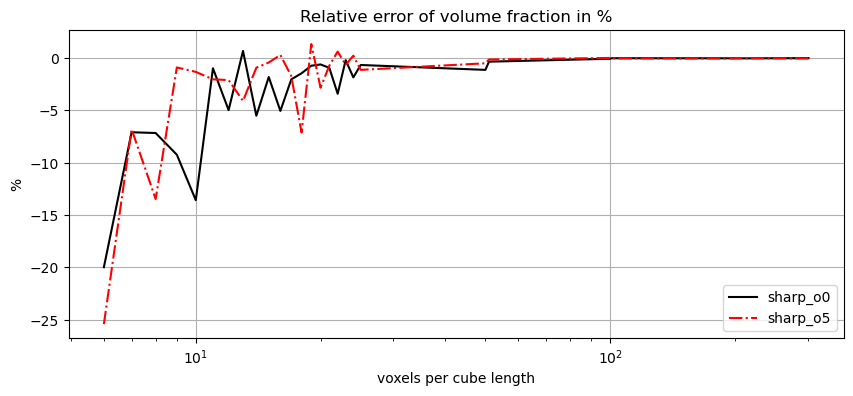

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    ax.semilogx(resolution, (fcc_results[f'overlap{int(100*o)}']['vol']['num']-fcc_results[f'overlap{int(100*o)}']['vol']['theo'])/fcc_results[f'overlap{int(100*o)}']['vol']['theo']*100, label=f'sharp_o{int(100*o)}', color=colors[i], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of volume fraction in %')
ax.legend()
ax.grid()
plt.show()

Relative error of surface area computation

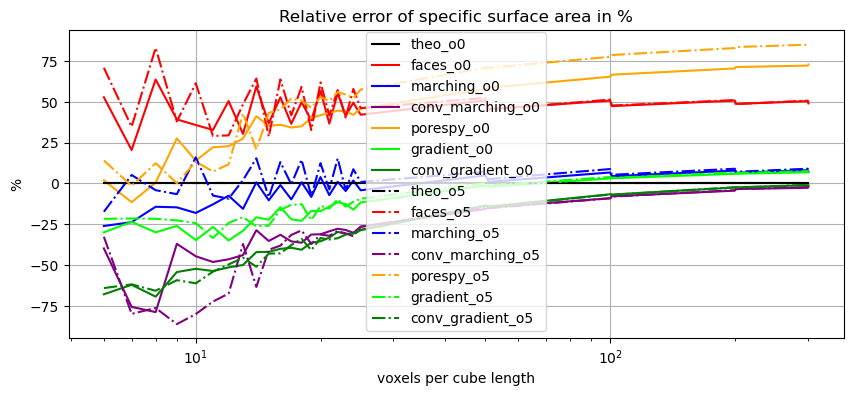

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods):
        rel_error = (fcc_results[f'overlap{int(100*o)}']['area'][method]-fcc_results[f'overlap{int(100*o)}']['area']['theo'])/fcc_results[f'overlap{int(100*o)}']['area']['theo']*100
        ax.semilogx(resolution, rel_error, label=method+f'_o{int(100*o)}', color=colors[j], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('%')
ax.set_title('Relative error of specific surface area in %')
ax.legend()
ax.grid()

plt.show()

And, last but not least, the computation times

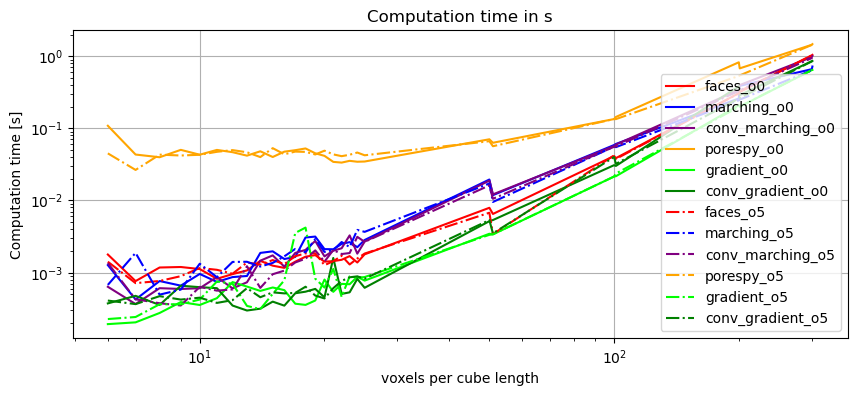

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
for i, o in enumerate(overlaps):
    for j, method in enumerate(methods[1:]):
        ax.loglog(resolution, fcc_results[f'overlap{int(100*o)}']['time'][method], label=method+f'_o{int(100*o)}', color=colors[j+1], linestyle=line_styles[i])

ax.set_xlabel('voxels per cube length')
ax.set_ylabel('Computation time [s]')
ax.set_title('Computation time in s')
ax.legend()
ax.grid()

plt.show()

### Save results to text file
Define a file name and write results dictionary as text table

In [8]:
file_name = "fcc_overlap0.txt"
output = {'pixels':resolution}
buffer = fcc_results['overlap0']
for key,s in buffer['vol'].items():
    header = 'vol_'+key
    output[header] = s
for key,s in buffer['area'].items():
    header = 'a_'+key
    output[header] = s
for key,s in buffer['time'].items():
    header = 't_'+key
    output[header] = s
for key,s in buffer['connected'].items():
    header = 'con_'+key
    output[header] = s
for key,s in buffer['taufactor'].items():
    header = 'tau_'+key
    output[header] = s

data.write_dict_to_txt(output, file_name)
print(f"Data written to {file_name}.")

Data written to fcc_overlap0.txt.
